In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import tensorflow as tf

In [3]:
from vaneska.models import Gaussian
from vaneska.photometry import PSFPhotometry

In [4]:
from tqdm import tqdm

In [5]:
from lightkurve import KeplerTargetPixelFile, LightCurve

In [6]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


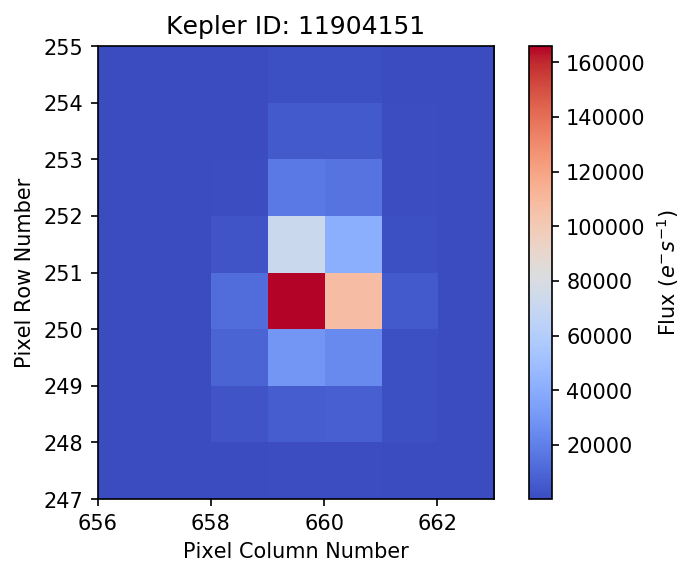

In [7]:
tpf.plot(scale=None, bkg=True, cmap='coolwarm')

In [8]:
gaussian = Gaussian(shape=tpf.shape[1:], col_ref=tpf.column, row_ref=tpf.row)

In [9]:
xc, yc = tpf.centroids()

In [10]:
fluxes = [tf.Variable(initial_value=np.nansum(tpf.flux, axis=(1, 2))[i], dtype=tf.float64)
          for i in range(10)]
cols = [tf.Variable(initial_value=xc[i], dtype=tf.float64,)
        for i in range(10)]
rows = [tf.Variable(initial_value=yc[i], dtype=tf.float64,)
        for i in range(10)]
a = [tf.Variable(initial_value=np.ones(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
b = [tf.Variable(initial_value=np.zeros(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
c = [tf.Variable(initial_value=np.ones(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
bkg = [tf.Variable(initial_value=np.nanmean(tpf.flux_bkg, axis=(1, 2))[i], dtype=tf.float64)
       for i in range(10)]

In [11]:
mean = [gaussian(fluxes[i], cols[i], rows[i], a[i], b[i], c[i]) + bkg[i] for i in tqdm(range(10))]

100%|██████████| 10/10 [00:00<00:00, 25.43it/s]


In [48]:
flat_field = tf.Variable(initial_value=np.ones_like(tpf.flux[0]), dtype=tf.float64)

In [49]:
data = tf.placeholder(dtype=tf.float64)

In [50]:
# Poisson likelihood
loss = tf.reduce_sum(tf.subtract(tf.multiply(mean, flat_field), tf.multiply(data, tf.log(mean) + tf.log(flat_field))))

In [54]:
var_list=[flat_field] + sum([fluxes, cols, rows, a, b, c, bkg], [])

In [57]:
grad = tf.gradients(loss, var_list)

In [59]:
session = tf.Session()
session.run(fetches=tf.global_variables_initializer())

In [60]:
session.run(grad, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

[array([[ -1.19379993e+03,  -1.70239009e+03,  -4.22161064e+03,
          -6.92042266e+03,  -8.45022322e+03,  -3.09728286e+03,
          -5.57089828e+02],
        [ -1.81355030e+03,  -4.43056077e+03,  -3.43508257e+04,
          -6.45183490e+04,  -6.36621023e+04,  -1.42989545e+04,
          -7.06736806e+02],
        [ -5.48849340e+02,  -2.90962867e+03,  -8.75079700e+04,
          -2.03526939e+05,  -1.40737604e+05,   8.19767634e+03,
          -4.04433031e+02],
        [ -9.79498755e+02,  -4.92538305e+03,  -9.95092675e+04,
          -1.14006634e+06,  -1.56022980e+04,   2.18946148e+05,
           4.69192254e+03],
        [ -7.11971046e+02,  -2.06488982e+03,   1.62962474e+04,
          -4.30060941e+04,   1.15866607e+06,   4.21409763e+05,
           1.40905390e+04],
        [ -3.59105283e+02,  -1.46263872e+03,  -4.86372245e+02,
          -1.60342247e+04,   1.98399939e+05,   8.47232696e+04,
           2.15064458e+03],
        [ -4.61392735e+02,  -6.74978446e+02,  -5.31768694e+03,
          -5.

In [61]:
session.run(loss, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

-51918859.753296755

In [62]:
#session.run(grad, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

In [63]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=loss, var_list=var_list, method='TNC')

In [67]:
psf_flux = []

In [ ]:
for i in tqdm(range((tpf.shape[0] - 10) // 10)):
    optimizer.minimize(session=session, feed_dict={data: tpf.flux[i*10:(i+1)*10] + tpf.flux_bkg[i*10:(i+1)*10]})
    psf_flux.append(session.run([fluxes]))


  0%|          | 0/448 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55143920.053731
  Number of iterations: 22
  Number of functions evaluations: 108



  0%|          | 1/448 [00:00<05:14,  1.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55145817.098884
  Number of iterations: 13
  Number of functions evaluations: 71



  0%|          | 2/448 [00:01<04:27,  1.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55157083.425431
  Number of iterations: 11
  Number of functions evaluations: 59



  1%|          | 3/448 [00:01<03:49,  1.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55170734.961734
  Number of iterations: 11
  Number of functions evaluations: 60



  1%|          | 4/448 [00:01<03:30,  2.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55178490.909911
  Number of iterations: 11
  Number of functions evaluations: 62



  1%|          | 5/448 [00:02<03:20,  2.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55189082.593952
  Number of iterations: 67
  Number of functions evaluations: 546



  1%|▏         | 6/448 [00:05<06:49,  1.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55182312.728352
  Number of iterations: 11
  Number of functions evaluations: 63



  2%|▏         | 7/448 [00:05<06:13,  1.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55188899.246393
  Number of iterations: 11
  Number of functions evaluations: 58



  2%|▏         | 8/448 [00:06<05:45,  1.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55197724.516283
  Number of iterations: 13
  Number of functions evaluations: 77



  2%|▏         | 9/448 [00:06<05:27,  1.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55196908.587529
  Number of iterations: 18
  Number of functions evaluations: 95



  2%|▏         | 10/448 [00:07<05:21,  1.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55192450.770382
  Number of iterations: 12
  Number of functions evaluations: 66



  2%|▏         | 11/448 [00:07<05:08,  1.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55196691.239150
  Number of iterations: 11
  Number of functions evaluations: 55



  3%|▎         | 12/448 [00:08<04:57,  1.47it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/jvmirca/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jvmirca/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55186218.455584
  Number of iterations: 8
  Number of functions evaluations: 136


  3%|▎         | 13/448 [00:09<05:14,  1.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55206369.001221
  Number of iterations: 11
  Number of functions evaluations: 64


  3%|▎         | 14/448 [00:09<05:03,  1.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55202992.705127
  Number of iterations: 12
  Number of functions evaluations: 59


  3%|▎         | 15/448 [00:10<04:54,  1.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55209831.644431
  Number of iterations: 19
  Number of functions evaluations: 198


  4%|▎         | 16/448 [00:12<05:24,  1.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55211184.074549
  Number of iterations: 12
  Number of functions evaluations: 61


  4%|▍         | 17/448 [00:12<05:15,  1.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55213490.978764
  Number of iterations: 12
  Number of functions evaluations: 63


  4%|▍         | 18/448 [00:12<05:06,  1.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55211886.957773
  Number of iterations: 12
  Number of functions evaluations: 65


  4%|▍         | 19/448 [00:13<04:58,  1.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55220027.308734
  Number of iterations: 12
  Number of functions evaluations: 62


  4%|▍         | 20/448 [00:13<04:51,  1.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55223024.586071
  Number of iterations: 31
  Number of functions evaluations: 158


  5%|▍         | 21/448 [00:14<04:56,  1.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55221585.669844
  Number of iterations: 30
  Number of functions evaluations: 193


  5%|▍         | 22/448 [00:15<05:03,  1.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55220672.086769
  Number of iterations: 12
  Number of functions evaluations: 60


  5%|▌         | 23/448 [00:16<04:56,  1.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55225285.714842
  Number of iterations: 11
  Number of functions evaluations: 61


  5%|▌         | 24/448 [00:16<04:52,  1.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55225042.714887
  Number of iterations: 12
  Number of functions evaluations: 70


  6%|▌         | 25/448 [00:17<04:47,  1.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230300.094731
  Number of iterations: 14
  Number of functions evaluations: 74


  6%|▌         | 26/448 [00:17<04:43,  1.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55224904.526137
  Number of iterations: 13
  Number of functions evaluations: 66


  6%|▌         | 27/448 [00:17<04:38,  1.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233911.518566
  Number of iterations: 12
  Number of functions evaluations: 71


  6%|▋         | 28/448 [00:18<04:33,  1.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55235888.665589
  Number of iterations: 11
  Number of functions evaluations: 50


  6%|▋         | 29/448 [00:18<04:28,  1.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233190.525984
  Number of iterations: 12
  Number of functions evaluations: 56


  7%|▋         | 30/448 [00:18<04:23,  1.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55229647.629383
  Number of iterations: 12
  Number of functions evaluations: 63


  7%|▋         | 31/448 [00:19<04:19,  1.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55233485.702128
  Number of iterations: 12
  Number of functions evaluations: 68


  7%|▋         | 32/448 [00:19<04:15,  1.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55234455.766230
  Number of iterations: 14
  Number of functions evaluations: 83


  7%|▋         | 33/448 [00:20<04:13,  1.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55232491.968660
  Number of iterations: 14
  Number of functions evaluations: 77


  8%|▊         | 34/448 [00:20<04:11,  1.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55229858.271501
  Number of iterations: 11
  Number of functions evaluations: 58


  8%|▊         | 35/448 [00:21<04:09,  1.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233340.863915
  Number of iterations: 12
  Number of functions evaluations: 59


  8%|▊         | 36/448 [00:21<04:07,  1.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55232887.956449
  Number of iterations: 13
  Number of functions evaluations: 70


  8%|▊         | 37/448 [00:22<04:04,  1.68it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231733.231333
  Number of iterations: 12
  Number of functions evaluations: 69


  8%|▊         | 38/448 [00:22<04:02,  1.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55224290.529779
  Number of iterations: 12
  Number of functions evaluations: 62


  9%|▊         | 39/448 [00:22<04:00,  1.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230066.708206
  Number of iterations: 10
  Number of functions evaluations: 49


  9%|▉         | 40/448 [00:23<03:57,  1.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233185.076797
  Number of iterations: 10
  Number of functions evaluations: 52


  9%|▉         | 41/448 [00:23<03:54,  1.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231416.770871
  Number of iterations: 13
  Number of functions evaluations: 78


  9%|▉         | 42/448 [00:24<03:53,  1.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230291.595889
  Number of iterations: 12
  Number of functions evaluations: 60


 10%|▉         | 43/448 [00:24<03:50,  1.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230727.964244
  Number of iterations: 11
  Number of functions evaluations: 66


 10%|▉         | 44/448 [00:24<03:48,  1.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55230865.478695
  Number of iterations: 29
  Number of functions evaluations: 154


 10%|█         | 45/448 [00:25<03:50,  1.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233414.299878
  Number of iterations: 11
  Number of functions evaluations: 61


 10%|█         | 46/448 [00:26<03:48,  1.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231073.113024
  Number of iterations: 13
  Number of functions evaluations: 71


 10%|█         | 47/448 [00:26<03:46,  1.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231307.177093
  Number of iterations: 49
  Number of functions evaluations: 332


 11%|█         | 48/448 [00:28<03:56,  1.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233986.441375
  Number of iterations: 11
  Number of functions evaluations: 63


 11%|█         | 49/448 [00:28<03:54,  1.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55233421.025401
  Number of iterations: 29
  Number of functions evaluations: 131


 11%|█         | 50/448 [00:29<03:55,  1.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55229683.907408
  Number of iterations: 14
  Number of functions evaluations: 67


 11%|█▏        | 51/448 [00:29<03:53,  1.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55226717.161915
  Number of iterations: 11
  Number of functions evaluations: 61


 12%|█▏        | 52/448 [00:30<03:50,  1.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55220264.678517
  Number of iterations: 169
  Number of functions evaluations: 1260


 12%|█▏        | 53/448 [00:38<04:43,  1.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230901.053409
  Number of iterations: 25
  Number of functions evaluations: 114


 12%|█▏        | 54/448 [00:38<04:43,  1.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55229944.765604
  Number of iterations: 314
  Number of functions evaluations: 1260


 12%|█▏        | 55/448 [00:45<05:27,  1.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55232514.610978
  Number of iterations: 26
  Number of functions evaluations: 141


 12%|█▎        | 56/448 [00:46<05:26,  1.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233973.556731
  Number of iterations: 35
  Number of functions evaluations: 195


 13%|█▎        | 57/448 [00:47<05:27,  1.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55235793.121665
  Number of iterations: 17
  Number of functions evaluations: 75


 13%|█▎        | 58/448 [00:48<05:23,  1.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55225725.794269
  Number of iterations: 82
  Number of functions evaluations: 356


 13%|█▎        | 59/448 [00:50<05:31,  1.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55203685.991957
  Number of iterations: 66
  Number of functions evaluations: 284


 13%|█▎        | 60/448 [00:51<05:35,  1.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55235767.655846
  Number of iterations: 22
  Number of functions evaluations: 143


 14%|█▎        | 61/448 [00:52<05:34,  1.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55236528.622204
  Number of iterations: 23
  Number of functions evaluations: 109


 14%|█▍        | 62/448 [00:53<05:32,  1.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55234684.536191
  Number of iterations: 13
  Number of functions evaluations: 71


 14%|█▍        | 63/448 [00:53<05:29,  1.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231446.085267
  Number of iterations: 17
  Number of functions evaluations: 92


 14%|█▍        | 64/448 [00:54<05:26,  1.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55237421.984647
  Number of iterations: 210
  Number of functions evaluations: 856


 15%|█▍        | 65/448 [00:59<05:50,  1.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55236529.335144
  Number of iterations: 29
  Number of functions evaluations: 165


 15%|█▍        | 66/448 [01:00<05:49,  1.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55236147.029337
  Number of iterations: 18
  Number of functions evaluations: 85


 15%|█▍        | 67/448 [01:00<05:46,  1.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55228171.577542
  Number of iterations: 22
  Number of functions evaluations: 130


 15%|█▌        | 68/448 [01:01<05:45,  1.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233646.906522
  Number of iterations: 315
  Number of functions evaluations: 1260


 15%|█▌        | 69/448 [01:09<06:21,  1.01s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55234557.704230
  Number of iterations: 28
  Number of functions evaluations: 180


 16%|█▌        | 70/448 [01:10<06:21,  1.01s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233955.948287
  Number of iterations: 17
  Number of functions evaluations: 84


 16%|█▌        | 71/448 [01:11<06:17,  1.00s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55228453.902940
  Number of iterations: 170
  Number of functions evaluations: 689


 16%|█▌        | 72/448 [01:15<06:33,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55233427.655214
  Number of iterations: 19
  Number of functions evaluations: 122


 16%|█▋        | 73/448 [01:16<06:30,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55231080.935136
  Number of iterations: 16
  Number of functions evaluations: 78


 17%|█▋        | 74/448 [01:16<06:26,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55230700.151421
  Number of iterations: 94
  Number of functions evaluations: 376


 17%|█▋        | 75/448 [01:18<06:31,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55224316.292805
  Number of iterations: 16
  Number of functions evaluations: 77


 17%|█▋        | 76/448 [01:19<06:27,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55224954.934042
  Number of iterations: 32
  Number of functions evaluations: 134


 17%|█▋        | 77/448 [01:19<06:25,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55222705.933163
  Number of iterations: 19
  Number of functions evaluations: 97


 17%|█▋        | 78/448 [01:20<06:21,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55219691.392490
  Number of iterations: 19
  Number of functions evaluations: 94


 18%|█▊        | 79/448 [01:21<06:18,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55212650.179919
  Number of iterations: 31
  Number of functions evaluations: 201


 18%|█▊        | 80/448 [01:22<06:18,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55211350.049896
  Number of iterations: 98
  Number of functions evaluations: 405


 18%|█▊        | 81/448 [01:25<06:26,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55210481.197120
  Number of iterations: 19
  Number of functions evaluations: 117


 18%|█▊        | 82/448 [01:26<06:24,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55207736.806941
  Number of iterations: 19
  Number of functions evaluations: 102


 19%|█▊        | 83/448 [01:26<06:21,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55203424.479620
  Number of iterations: 24
  Number of functions evaluations: 121


 19%|█▉        | 84/448 [01:27<06:18,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55204386.647787
  Number of iterations: 213
  Number of functions evaluations: 859


 19%|█▉        | 85/448 [01:32<06:35,  1.09s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55201866.820968
  Number of iterations: 22
  Number of functions evaluations: 99


 19%|█▉        | 86/448 [01:33<06:32,  1.08s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55200048.336405
  Number of iterations: 16
  Number of functions evaluations: 72


 19%|█▉        | 87/448 [01:33<06:28,  1.08s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55194952.236722
  Number of iterations: 19
  Number of functions evaluations: 96


 20%|█▉        | 88/448 [01:34<06:25,  1.07s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55196008.225840
  Number of iterations: 16
  Number of functions evaluations: 88


 20%|█▉        | 89/448 [01:34<06:21,  1.06s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55197274.680157
  Number of iterations: 28
  Number of functions evaluations: 145


 20%|██        | 90/448 [01:35<06:19,  1.06s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55193573.125589
  Number of iterations: 14
  Number of functions evaluations: 71


 20%|██        | 91/448 [01:35<06:16,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55189412.765906
  Number of iterations: 16
  Number of functions evaluations: 84


 21%|██        | 92/448 [01:36<06:12,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55193509.969056
  Number of iterations: 22
  Number of functions evaluations: 112


 21%|██        | 93/448 [01:37<06:10,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55183107.367557
  Number of iterations: 22
  Number of functions evaluations: 217


 21%|██        | 94/448 [01:38<06:11,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55182994.644293
  Number of iterations: 23
  Number of functions evaluations: 226


 21%|██        | 95/448 [01:40<06:12,  1.06s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55181764.945402
  Number of iterations: 25
  Number of functions evaluations: 107


 21%|██▏       | 96/448 [01:40<06:10,  1.05s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55183335.690513
  Number of iterations: 13
  Number of functions evaluations: 62


 22%|██▏       | 97/448 [01:41<06:06,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55180924.136827
  Number of iterations: 23
  Number of functions evaluations: 120


 22%|██▏       | 98/448 [01:42<06:04,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55180717.516074
  Number of iterations: 17
  Number of functions evaluations: 73


 22%|██▏       | 99/448 [01:42<06:01,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55176907.147743
  Number of iterations: 21
  Number of functions evaluations: 124


 22%|██▏       | 100/448 [01:43<05:59,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55179396.584000
  Number of iterations: 50
  Number of functions evaluations: 216


 23%|██▎       | 101/448 [01:44<05:58,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55180358.689726
  Number of iterations: 43
  Number of functions evaluations: 183


 23%|██▎       | 102/448 [01:45<05:59,  1.04s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55179378.342668
  Number of iterations: 25
  Number of functions evaluations: 110


 23%|██▎       | 103/448 [01:46<05:56,  1.03s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55173446.504369
  Number of iterations: 315
  Number of functions evaluations: 1260


 23%|██▎       | 104/448 [01:53<06:15,  1.09s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55175605.985677
  Number of iterations: 16
  Number of functions evaluations: 83


 23%|██▎       | 105/448 [01:54<06:12,  1.09s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55179338.137856
  Number of iterations: 22
  Number of functions evaluations: 108


 24%|██▎       | 106/448 [01:54<06:10,  1.08s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55177586.158396
  Number of iterations: 315
  Number of functions evaluations: 1260


 24%|██▍       | 107/448 [02:01<06:28,  1.14s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55173217.605426
  Number of iterations: 19
  Number of functions evaluations: 110


 24%|██▍       | 108/448 [02:02<06:25,  1.14s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55173056.831227
  Number of iterations: 19
  Number of functions evaluations: 92


 24%|██▍       | 109/448 [02:03<06:23,  1.13s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55171649.203463
  Number of iterations: 22
  Number of functions evaluations: 140


 25%|██▍       | 110/448 [02:03<06:21,  1.13s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55167102.512733
  Number of iterations: 19
  Number of functions evaluations: 122


 25%|██▍       | 111/448 [02:04<06:18,  1.12s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55164121.494130
  Number of iterations: 11
  Number of functions evaluations: 46


 25%|██▌       | 112/448 [02:05<06:15,  1.12s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55167567.623386
  Number of iterations: 25
  Number of functions evaluations: 124


 25%|██▌       | 113/448 [02:05<06:12,  1.11s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55169407.968312
  Number of iterations: 13
  Number of functions evaluations: 57


 25%|██▌       | 114/448 [02:06<06:09,  1.11s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55168068.329495
  Number of iterations: 22
  Number of functions evaluations: 116


 26%|██▌       | 115/448 [02:06<06:07,  1.10s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55161617.627918
  Number of iterations: 313
  Number of functions evaluations: 1260


 26%|██▌       | 116/448 [02:14<06:23,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55164093.058495
  Number of iterations: 22
  Number of functions evaluations: 134


 26%|██▌       | 117/448 [02:14<06:21,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55164981.809999
  Number of iterations: 20
  Number of functions evaluations: 110


 26%|██▋       | 118/448 [02:15<06:19,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55161112.131625
  Number of iterations: 21
  Number of functions evaluations: 91


 27%|██▋       | 119/448 [02:16<06:16,  1.14s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55158664.799195
  Number of iterations: 158
  Number of functions evaluations: 646


 27%|██▋       | 120/448 [02:20<06:23,  1.17s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55160183.560497
  Number of iterations: 19
  Number of functions evaluations: 111


 27%|██▋       | 121/448 [02:21<06:21,  1.17s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: -55157005.200866
  Number of iterations: 314
  Number of functions evaluations: 1260


 27%|██▋       | 122/448 [02:28<06:36,  1.22s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55155963.416008
  Number of iterations: 16
  Number of functions evaluations: 111


 27%|██▋       | 123/448 [02:28<06:33,  1.21s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55144806.972311
  Number of iterations: 23
  Number of functions evaluations: 225


 28%|██▊       | 124/448 [02:30<06:33,  1.21s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55154205.759024
  Number of iterations: 9
  Number of functions evaluations: 36


 28%|██▊       | 125/448 [02:30<06:29,  1.21s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55150785.899815
  Number of iterations: 11
  Number of functions evaluations: 55


 28%|██▊       | 126/448 [02:31<06:25,  1.20s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55150029.214006
  Number of iterations: 26
  Number of functions evaluations: 128


 28%|██▊       | 127/448 [02:31<06:23,  1.19s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55146279.853527
  Number of iterations: 16
  Number of functions evaluations: 90


 29%|██▊       | 128/448 [02:32<06:20,  1.19s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55148111.986264
  Number of iterations: 25
  Number of functions evaluations: 129


 29%|██▉       | 129/448 [02:32<06:18,  1.19s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55147687.558205
  Number of iterations: 16
  Number of functions evaluations: 95


 29%|██▉       | 130/448 [02:33<06:15,  1.18s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55147848.525256
  Number of iterations: 25
  Number of functions evaluations: 114


 29%|██▉       | 131/448 [02:34<06:13,  1.18s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55144011.138563
  Number of iterations: 19
  Number of functions evaluations: 103


 29%|██▉       | 132/448 [02:34<06:10,  1.17s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55145096.470256
  Number of iterations: 11
  Number of functions evaluations: 55


 30%|██▉       | 133/448 [02:35<06:07,  1.17s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55147144.989216
  Number of iterations: 36
  Number of functions evaluations: 165


 30%|██▉       | 134/448 [02:35<06:05,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55144974.787587
  Number of iterations: 19
  Number of functions evaluations: 105


 30%|███       | 135/448 [02:36<06:03,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55140532.786099
  Number of iterations: 24
  Number of functions evaluations: 142


 30%|███       | 136/448 [02:37<06:01,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55140719.861303
  Number of iterations: 56
  Number of functions evaluations: 234


 31%|███       | 137/448 [02:38<06:00,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55142323.561592
  Number of iterations: 17
  Number of functions evaluations: 90


 31%|███       | 138/448 [02:39<05:57,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55135517.990846
  Number of iterations: 9
  Number of functions evaluations: 39


 31%|███       | 139/448 [02:39<05:54,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55136712.657471
  Number of iterations: 28
  Number of functions evaluations: 420


 31%|███▏      | 140/448 [02:42<05:57,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55134046.487206
  Number of iterations: 20
  Number of functions evaluations: 91


 31%|███▏      | 141/448 [02:43<05:55,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55135815.637111
  Number of iterations: 26
  Number of functions evaluations: 144


 32%|███▏      | 142/448 [02:44<05:53,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55137073.259457
  Number of iterations: 17
  Number of functions evaluations: 106


 32%|███▏      | 143/448 [02:44<05:51,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55137634.864568
  Number of iterations: 20
  Number of functions evaluations: 101


 32%|███▏      | 144/448 [02:45<05:49,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55133578.230882
  Number of iterations: 22
  Number of functions evaluations: 98


 32%|███▏      | 145/448 [02:46<05:47,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55138813.469540
  Number of iterations: 111
  Number of functions evaluations: 505


 33%|███▎      | 146/448 [02:49<05:49,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55139769.665662
  Number of iterations: 22
  Number of functions evaluations: 131


 33%|███▎      | 147/448 [02:49<05:47,  1.16s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55138214.543879
  Number of iterations: 16
  Number of functions evaluations: 69


 33%|███▎      | 148/448 [02:50<05:45,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55132756.783051
  Number of iterations: 16
  Number of functions evaluations: 102


 33%|███▎      | 149/448 [02:50<05:42,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55134845.188713
  Number of iterations: 90
  Number of functions evaluations: 389


 33%|███▎      | 150/448 [02:53<05:44,  1.16s/it]

In [25]:
psf_flux = np.asarray(psf_flux)

In [28]:
psf_flux = psf_flux.reshape(-1)

In [33]:
psf_lc = LightCurve(tpf.time[:len(psf_flux)], psf_flux).flatten().fold(0.837495)

In [40]:
aper_lc = LightCurve(tpf.time, np.nansum(tpf.flux, axis=(1, 2))).flatten().fold(0.837495)

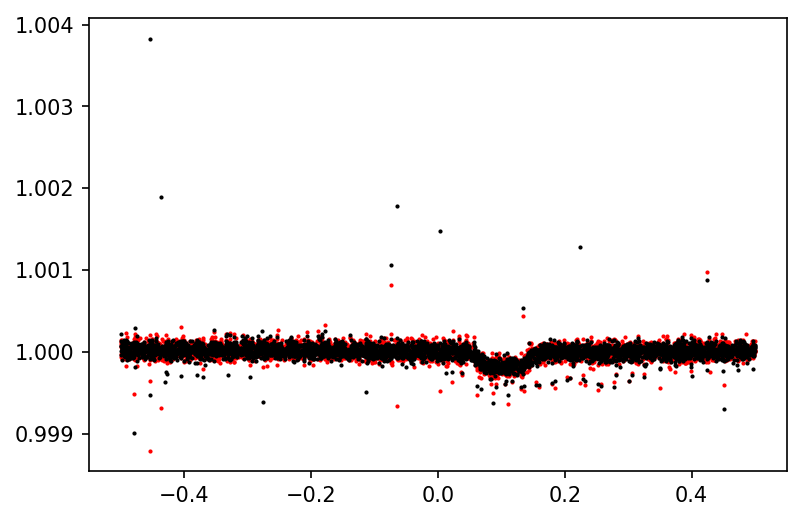

In [44]:
plt.plot(psf_lc.time, psf_lc.flux, 'ro', markersize=1)
plt.plot(aper_lc.time, aper_lc.flux, 'ko', markersize=1)

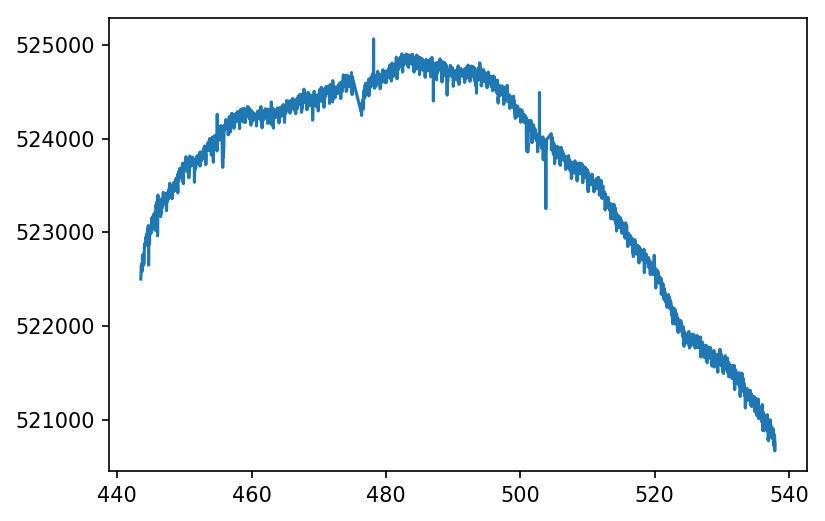

In [46]:
plt.plot(tpf.time[:len(psf_flux)], psf_flux)

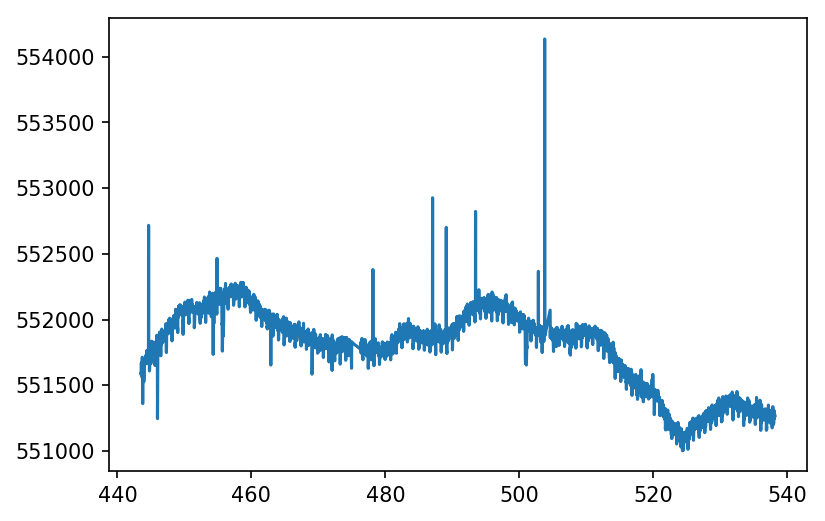

In [47]:
plt.plot(tpf.time, np.nansum(tpf.flux, axis=(1, 2)))